**Preamble/ functions** -- just run these, there shouldn't be anything that needs to be changed

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd
import os
import astropy.io
from astropy.io import fits
import astropy.units as u
import astropy.wcs as fitswcs
from astropy.wcs import WCS
from astroquery.gaia import Gaia
from astropy.io import ascii

from specutils import Spectrum1D, SpectrumCollection, SpectralRegion, SpectrumList
from PyAstronomy import pyasl
from keplersplinev2 import *
import warnings
warnings.filterwarnings('ignore')

import barycorrpy as bc

from io import StringIO

ModuleNotFoundError: No module named 'specutils'

In [2]:
#Setting up nicer plotting parameters
params = {
    'axes.labelsize': 9,
    'axes.labelpad': 2.5,
    'axes.titlesize': 12,
    'axes.linewidth':2,
    'axes.labelweight':3,
    'axes.titleweight':3,
    'font.size': 12,
    'legend.fontsize': 10,
    'lines.linewidth':2,
    'xtick.major.width': 2,
    'xtick.minor.width': 1,
    'xtick.major.size': 8,
    'xtick.minor.size': 5,
    'xtick.major.pad': 5,
    'xtick.labelsize':10,
    'xtick.minor.visible': True,
    'xtick.direction': 'in',
    'xtick.top': True,
    'xtick.bottom': True,
    'ytick.major.width':2,
    'ytick.minor.width':1,
    'ytick.major.size': 8,
    'ytick.minor.size': 5,
    'ytick.major.pad': 5,
    'ytick.labelsize':10,
    'ytick.minor.visible': True,
    'ytick.direction': 'in',
    'ytick.right': True,
    'ytick.left': True,
    'legend.frameon': True,
    #'font.sans-serif': "Helvetica",
    #'font.family': "sans-serif",
    'ps.usedistiller':'xpdf',
    'savefig.dpi': 300,
    'figure.figsize': [7,7]
    }

plt.rcParams.update(params)

In [3]:
#This function plots parsec files
#I would recommend using the parsec file I attached in the Github, if not, it might take some debugging

def plot_iso(file, start, end, step, sp=False, axis=None, ):
    with open(file, 'r') as f:
        chunks = f.read().split('#')
        chunks = chunks[14:]
        for i in range(int((end-start)/step)+1):
            num = start + step*i
            chunk = StringIO(chunks[i])
            df_iso = pd.read_csv(chunk,skiprows=0, delimiter = '\\s+') 
            df_iso['BP-RP'] = df_iso['G_BPmag']- df_iso['G_RPmag']
            if sp==False:
                plt.plot(df_iso['BP-RP'][2:210], df_iso['Gmag'][2:210],zorder=1, label = 'PARSEC 1.2S '+str(num)+' Myr', lw=1)
                plt.legend()
            if sp==True:
                axis.plot(df_iso['BP-RP'][2:210], df_iso['Gmag'][2:210],zorder=1, label = 'PARSEC 1.2S '+str(num)+' Myr', lw=1)
            
        

In [4]:
#This plots spectral types on a CMD

def plot_colors(axis, yval=40, alpha=0.15, xmin=-0.5, xmax=4.5,fontsize=10):
    colors = [
        {"min": -3, "max": -0.26, "alpha": alpha, "color": '#5b7cff', "label": 'O'},
        {"min": -0.25, "max": -0.038, "alpha": alpha, "color": '#6988ff', "label": 'B'},
        {"min": -0.037, "max": 0.327, "alpha": alpha, "color": '#93aaff', "label": 'A'},
        {"min": 0.326, "max": 0.767, "alpha": alpha, "color": '#dddeff', "label": 'F'},
        {"min": 0.768, "max": 0.984, "alpha": alpha, "color": '#ffebdf', "label": 'G'},
        {"min": 0.983, "max": 1.85, "alpha": alpha, "color": '#ffb177', "label": 'K'},
        {"min": 1.85, "max": 7.0, "alpha": alpha, "color": '#ffa448', "label": 'M'}
    ]

    for c in colors:
        if c["min"] < xmax and c["max"] > xmin: # Check if the color is within xmin and xmax
            bprp1 = max(c["min"], xmin)
            bprp2 = min(c["max"], xmax)

            axis.axvspan(bprp1, bprp2, alpha=c["alpha"], color=c["color"], zorder=1)
            val = bprp1 + (bprp2 - bprp1) / 2
            axis.annotate(c["label"], xy=(val, yval), xytext=(val, yval), fontsize=fontsize,zorder=8)
    axis.set_xlim(xmin, xmax)
    axis.set_ylim(15, -5)
    return

In [5]:
#MCMC Gaussian fitting, needed for the Cross-Correlation Function (CCF)

def G_fit(x,y, startpos, jumpwidth, nlink=50000, nburnin=10000):

    #Check out a full MCMC tutorial on Andrew Vanderburg's Github: https://github.com/avanderburg
    
    #Define the error - this value should be fine
    e = np.ones_like(y)*0.0005

    #Definie the log of the likelihood function: this determines how the MCMC chooses solutions
    def loglikelihood(p, x, y, e): 
        model = p[0] * np.exp(-(x-p[1])**2 / (p[2]**2)) + p[3]
        chisq = np.sum((y - model)**2 / e**2)
        loglikelihood = -0.5 * chisq  
        return loglikelihood

    #Setting up MCMC parameters
    npar = len(startpos)
    chain = np.zeros([nlink, npar]) * np.nan
    likelihoods = np.zeros(nlink) * np.nan
    all_log_likelihoods = np.ones(nlink)

    nlink = nlink
    startpos = startpos

    #MCMC loop:
    
    for i in range(nlink): 
        
        if i == 0: 
            thisposition = startpos 
            thisloglikelihood = loglikelihood(thisposition,x, y, e)
             
            
        if i >0: 

            
            lastposition = chain[i-1,:]
            
            trialposition = lastposition + np.random.normal(0, 1, npar) * jumpwidth
            if trialposition[2] < 0:
                trialposition[2] =0.0001
            if trialposition[0] < 0:
                trialposition[0] =0.0001
        
        
            
            trialloglikelihood = loglikelihood(trialposition,x,y,e)
            
            likelihoodratio = np.exp(trialloglikelihood - lastloglikelihood) 
            
            if likelihoodratio >= np.random.uniform(): 
                thisposition = trialposition
                thisloglikelihood = trialloglikelihood
                
            else: 
                thisposition = lastposition
                thisloglikelihood = lastloglikelihood
                
        chain[i,:] = thisposition 
        all_log_likelihoods[i] = thisloglikelihood 
        lastloglikelihood = thisloglikelihood 
    bchain = chain[nburnin:,:]
    
    return bchain

In [12]:
#Function that converts apparent to absolute magnitude 

def apparent_to_absolute(apparent_mag, parallax):
    '''
    apparent_mag: apparent magnitude of the target
    parallax: parallax of the target in milliarcseconds (mas)
    '''
    #From Jack Schulte's Github: https://github.com/jackschulte
    parallax_as = parallax / 1000
    distance = 1 / parallax_as # distance in pc (assuming small angle approximation is valid)
    absolute_mag = apparent_mag - 5 * np.log10(distance) + 5

    return absolute_mag

In [8]:
#This is the main function for determining SALT RVs

def SALT_RV(target, template, DR3name= None, minwl=4000, maxwl=5000, stepsize=0.05, rvmin=-100, rvmax=100, 
            bkspace=15, gwidth=40, jump_array= [0.0002, 0.05, 0.05, 0.0002],
            nlink=4000, nburnin=2000, parsec_file=None, start=None, end=None, step=None, split=5):
    

    target = fits.open(target)
    template= fits.open(template)
    '''Parameter description:
    target: Opened fits file for SALT, ideally with a Gaia DR3 ID in the 'Object' column of the header. This should be in the .uwm format, 
    in either the H or R band, but you then need to adjust the wavelength range accordingly.
    template: Opened fits file of the template spectrum you wish to use. We used spectra from pollux, which works well for us.
    DR3name: set to None by default, but if the Gaia DR3 name is not in the header, you need to input the value manually as a string. 
    minwl: The minimum wavelength you wish to use for the RV analysis.
    maxwl: The maximum wavelngth you wish to use for the RV analysis.
    stepsize: The stepping between RVs in the CCF
    rvmin: The minimum RV to sample.
    rvmax: The maximum RV to sample
    bkspace: The break point spacing used in the spline fitting of the spectrum. 
    gwidth: The width of the CCF to be approximated by a Gaussian.
    jump_array: The jump array used by the MCMC fit. Can usually be left as is.
    nlink: The total number of links in the MCMC.
    nburnin: The number of "burn-in" links, i.e the ones removed from the analysis.
    parsec_file: The parsec isochrone file you wish to use.
    start: The minimum isochrone age used.
    end: The maximum isochrone age used.
    step: The steps between isochrone ages.
    split: The number of chunks you wish to split the wavelength range into.

    '''

    #Setting up plotting params now
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(5, 6,  wspace=0.7, hspace=0.42)
    ax1  = plt.subplot(gs[0,0:6])
    ax2 = plt.subplot(gs[1,0:3])
    ax21 = plt.subplot(gs[1,3:6])
    ax3 = plt.subplot(gs[2, 0:3])
    ax4 = plt.subplot(gs[2:4, 3:6])
    ax5= plt.subplot(gs[3,0:3])

    #Reading in the target data
    target_data = target[0].data
    target_header = target[0].header

    #Querying Gaia for info
    if DR3name== None:
        header= target[0].header
        DR3_name =header['Object'].split()[2]
        print('Gaia DR3 '+str(DR3_name))
        qry = "SELECT * FROM gaiadr3.gaia_source gs WHERE gs.source_id in (" + DR3_name + ");"
        job = Gaia.launch_job_async( qry )
        results = job.get_results()
        ra = results['ra'][0]
        dec = results['dec'][0]
        g_mag = results['phot_g_mean_mag'][0]
        par = results['parallax'][0]
        if type(results['ag_gspphot'][0]) == int or type(results['ag_gspphot'][0]) == float:
            abs_g_mag = apparent_to_absolute(g_mag, par) - results['ag_gspphot'][0]
        else:
            abs_g_mag = apparent_to_absolute(g_mag, par)
        if type(results['ebpminrp_gspphot'][0]) == int or type(results['ebpminrp_gspphot'][0]) == float:
            bp_rp = results['bp_rp'][0]- results['ebpminrp_gspphot'][0]
        else:
            bp_rp = results['bp_rp'][0]
            
    #If Gaia DR3 name is not in the header, we can choose to query Gaia with the ID inputted in the function.
    else:
        DR3_name =DR3name
        print('Gaia DR3 '+str(DR3_name))
        qry = "SELECT * FROM gaiadr3.gaia_source gs WHERE gs.source_id in (" + DR3_name + ");"
        job = Gaia.launch_job_async( qry )
        results = job.get_results()
        ra = results['ra'][0]
        dec = results['dec'][0]
        g_mag = results['phot_g_mean_mag'][0]
        par = results['parallax'][0]
        if type(results['ag_gspphot'][0]) == int or type(results['ag_gspphot'][0]) == float:
            abs_g_mag = apparent_to_absolute(g_mag, par) - results['ag_gspphot'][0]
        else:
            abs_g_mag = apparent_to_absolute(g_mag, par)
        if type(results['ebpminrp_gspphot'][0]) == int or type(results['ebpminrp_gspphot'][0]) == float:
            bp_rp = results['bp_rp'][0]- results['ebpminrp_gspphot'][0]
        else:
            bp_rp = results['bp_rp'][0]


    #SALT coordinates
    lat = 32.37582222
    long = 20.81080833
    alt = 1798
    JD = float(target[0].header['JD'])

    #Getting barycenter correction value
    vel = bc.get_BC_vel(JDUTC=JD,ra=ra, dec=dec, lat=lat, longi = long, alt=alt)

    
    #create WCS object for the 1D SALT Spectrum
    target_wcs = fitswcs.WCS(header={'CDELT1': target_header['CDELT1'], 'CRVAL1': target_header['CRVAL1'],
                                       'CTYPE1': 'WAVE',
                                       'CRPIX1': target_header['CRPIX1']})

    
    target_flux = (target_data ) * u.Jy
    target_spec1D = Spectrum1D(flux=target_flux, wcs=target_wcs)
    data ={ 'wl': target_spec1D.spectral_axis.value,
     'flux': target_spec1D.flux.value.astype(float)}
    df_target_f= pd.DataFrame(data)

    #Making the cuts for the min and max wavelength
    df_target_slice = df_target_f[df_target_f['wl'].between(minwl,maxwl)]

    #Flattening the spectrum
    s = keplersplinev2(np.array(df_target_slice['wl']), np.array(df_target_slice['flux']),bkspace = bkspace)
    df_target_slice['flat_flux'] = np.array(df_target_slice['flux']) / s

    
    
    #Reading in, slicing, and flattening the template spectrum
    template[1].data=template[1].data[(template[1].data.wavelength>minwl)&(template[1].data.wavelength<maxwl)]
    template[1].data.flux=template[1].data.flux/np.nanmedian(template[1].data.flux)
    s = keplersplinev2(template[1].data.wavelength, template[1].data.flux,bkspace = bkspace)
    template[1].data.flux = template[1].data.flux / s

    #Loop to cover the all of the splits for the different wavelengths
    rv_array = np.array([])
    for i in range(split):
        midwl_i = minwl + i*(maxwl-minwl)/split
        midwl_f = minwl + (i+1)*(maxwl-minwl)/split
        df_target= df_target_f[df_target_f['wl'].between(midwl_i,midwl_f)]
        
        #Flattening
        s = keplersplinev2(np.array(df_target['wl']), np.array(df_target['flux']),bkspace = bkspace)
        
        #Barycenter correction
        vc=299792.458
        target_wl = np.array(df_target['wl']) * (1+(vel[0][0]/1000)/vc)
        target_fflux = np.array(df_target['flux'])/s


        temp_temp =template[1].data[(template[1].data.wavelength>midwl_i)&(template[1].data.wavelength<midwl_f)]
    
        temp_temp.flux = temp_temp.flux/np.nanmedian(temp_temp.flux)
        template_finalwl=temp_temp.wavelength
        template_finalflux=temp_temp.flux
        s = keplersplinev2(template_finalwl, template_finalflux,bkspace = bkspace)
        template_finalflux=template_finalflux/s

        #Computation of the CCF
        rv, cc = pyasl.crosscorrRV(target_wl, target_fflux, 
                                   template_finalwl, template_finalflux, 
                                   rvmin, rvmax, stepsize, skipedge=200)

        #Estimate for the peak of the CCF
        maxind = np.argmax(cc)
        guess_rv=rv[maxind]
    
        data_cc = {
            'rv': rv,
            'cc':cc/max(cc)
        }
        df_cc = pd.DataFrame(data_cc)
        df_ccf= df_cc[df_cc['rv'].between(guess_rv-gwidth/2,guess_rv+ gwidth/2)]

        #Gaussian fit to the CCF output
        bchain = G_fit(df_ccf['rv'], df_ccf['cc'], [0.005, np.mean(df_ccf['rv']), 
                                                                  np.std(df_ccf['rv']), np.min(df_ccf['cc'])], jump_array,
                      nlink=nlink, nburnin=nburnin)
        
        #labels=['Amplitude', 'mean', 'std dev', 'C']
        
        A = np.median(bchain[:,0])
        mu = np.median(bchain[:,1])
        sigma = np.median(bchain[:,2])
        C = np.median(bchain[:,3])
        gauss = A* np.exp(-(np.array(df_ccf['rv'])-mu)**2 / (sigma**2))+C
        
        abs_rv = mu
        #Adding the mean of the Gassian to an array
        rv_array = np.append(rv_array, abs_rv)

        #Plotting the output
        if i ==0:
            ax3.plot(rv, cc/max(cc), c='black' , label='CCF Output')
            ax3.plot(df_ccf['rv'], df_ccf['cc'], c='red', label='CCF Subsection')
            ax3.legend()
        if i > 0:
            ax3.plot(rv, cc/max(cc), c='black' )
            ax3.plot(df_ccf['rv'], df_ccf['cc'], c='red')

        ax5.plot(df_ccf['rv'], df_ccf['cc']+ i* 0.01, c='red', lw=2.0, alpha=0.5)
        ax5.plot(df_ccf['rv'], gauss+ i * 0.01, lw=2.0, alpha=0.5)


    #Plotting the whole spectrum, along with out chosen wl range
    ax1.plot(target_spec1D.spectral_axis, target_spec1D.flux,lw=0.5, c='black', label='Gaia DR3 '+ DR3_name+ ' Spectrum')
    ax1.plot(df_target_slice['wl'], df_target_slice['flux'], lw=0.5, c='orange', label='Target Spectrum')
    ax1.set_xlabel('Wavelength (A)') 
    ax1.set_ylabel('Flux')
    ax1.legend()
    
    #Plotting the flattened target and template spectra  
    ax2.plot(template[1].data.wavelength, template[1].data.flux, lw=1.0, c='green', label='Template Spectrum')
    ax2.plot(df_target_slice['wl'], df_target_slice['flat_flux'], lw=1.0, c='orange', label='Target Spectrum')
    ax2.set_xlabel('Wavelength (A)') 
    ax2.set_ylabel('Normalized Flux')
    ax2.legend()


    #Zoomed in view to better see absorbtion lines
    ax21.plot(template[1].data.wavelength, template[1].data.flux, lw=1.0, c='green', label='Template Spectrum')
    ax21.plot(df_target_slice['wl'], df_target_slice['flat_flux'], lw=1.0, c='orange', label='Target Spectrum')
    ax21.set_xlabel('Wavelength (A)') 
    ax21.set_ylabel('Normalized Flux')
    ax21.set_xlim((minwl+maxwl)/2 -30, (minwl+maxwl)/2 + 30)
    ax21.legend()

    #Setting labels for the CCF output
    ax3.set_xlabel('RV (km/s)') 

    #Setting labels for the Gassian fitting
    ax3.set_ylabel('CCF')

    ax5.set_xlabel('RV (km/s)') 
    ax5.set_ylabel('CCF + Constant')


    #Correcting the spectral axis for both barycenter and Doppler effects
    corr_wl=np.array(df_target_slice['wl'])* (1+(vel[0][0]/1000)/vc)*(1-((abs_rv)/vc))

    
    #Plotting the corrected and shifted spectrum
    ax6 = plt.subplot(gs[4,:3])
    ax6.plot(template[1].data.wavelength, template[1].data.flux, lw=1.0, c='green', label='Template')
    ax6.plot(corr_wl, df_target_slice['flat_flux'], lw=1.0, c='orange', label='Fitted Target')
    ax6.set_xlabel('Wavelength (A)') 
    ax6.set_ylabel('Normalized Flux')
    ax6.set_title('RV = '+str(np.round(float(np.median(rv_array)), 3))+'+/-'+ str(np.round(np.std(rv_array), 3))+' km/s', fontsize=13)
    ax6.legend()

    #Zoomed in view of the corrected and shited spectrum
    ax61 = plt.subplot(gs[4,3:6])
    ax61.plot(template[1].data.wavelength, template[1].data.flux, lw=1.0, c='green', label='Template')
    ax61.plot(corr_wl, df_target_slice['flat_flux'], lw=1.0, c='orange', label='Fitted Target')
    ax61.set_xlabel('Wavelength (A)') 
    ax61.set_ylabel('Normalized Flux')
    ax61.set_xlim((minwl+maxwl)/2 -30, (minwl+maxwl)/2 + 30)
    ax61.legend()

    
    #Print the average RV over all of the splits
    print('RV = '+str(np.round(float(np.median(rv_array)), 3))+'+/-'+ str(np.round(np.std(rv_array), 3))+' km/s')

    #Plotting the CMD location of the target
    if parsec_file != None:
        plot_iso(parsec_file, sp=True, axis=ax4, start = start, end = end, step = step)
    plot_colors(axis=ax4, yval=-3.5, alpha=0.15, xmin=-0.5, xmax=4,fontsize=10)
    ax4.scatter(bp_rp, abs_g_mag, s=40, c='black')
    bluex=[-1.937E-1,6.5894E-1]
    bluey=[4.3871,-4.87]
    redx=[3.1126E-1,1.6108]
    redy=[4.7419,-4.871]
    ax4.plot(redx,redy,linestyle='dashed',color='red', zorder=1, lw=1.0)
    ax4.plot(bluex,bluey,linestyle='dashed',color='blue', zorder=1, lw=1.0)
    ax4.set_xlabel('BP-RP - E(BP-RP) (mag)',fontsize=10)
    ax4.set_ylabel('Absolute Gaia Magnitude',fontsize=10)
    ax4.legend()
    plt.show()
    return np.round(float(np.median(rv_array)), 3)
        

In [9]:
#This is the main function for determining SALT RVs

def SALT_RV_Multi(target, template, temptype=None, DR3name= None, trim=0.15, order_array=[10, 11, 12], stepsize=0.05, rvmin=-100, rvmax=100,  
            bkspace=15, gwidth=40, jump_array= [0.0002, 0.05, 0.05, 0.0002],
            nlink=4000, nburnin=2000, parsec_file=None, start=None, end=None, step=None):


    '''Parameter description:
    target: Opened fits file for SALT, ideally with a Gaia DR3 ID in the 'Object' column of the header. This should be in the .uwm format, 
    in either the H or R band, but you then need to adjust the wavelength range accordingly.
    template: Opened fits file of the template spectrum you wish to use. We used spectra from pollux, which works well for us.
    DR3name: set to None by default, but if the Gaia DR3 name is not in the header, you need to input the value manually as a string. 
    minwl: The minimum wavelength you wish to use for the RV analysis.
    maxwl: The maximum wavelngth you wish to use for the RV analysis.
    stepsize: The stepping between RVs in the CCF
    rvmin: The minimum RV to sample.
    rvmax: The maximum RV to sample
    bkspace: The break point spacing used in the spline fitting of the spectrum. 
    gwidth: The width of the CCF to be approximated by a Gaussian.
    jump_array: The jump array used by the MCMC fit. Can usually be left as is.
    nlink: The total number of links in the MCMC.
    nburnin: The number of "burn-in" links, i.e the ones removed from the analysis.
    parsec_file: The parsec isochrone file you wish to use.
    start: The minimum isochrone age used.
    end: The maximum isochrone age used.
    step: The steps between isochrone ages.
    split: The number of chunks you wish to split the wavelength range into.

    '''

    #Setting up plotting params now
    fig = plt.figure(figsize=(12, 12))
    gs = gridspec.GridSpec(4, 6,  wspace=0.7, hspace=0.42)
    ax1  = plt.subplot(gs[0,0:6])
    
    ax2 = plt.subplot(gs[1, 0:2])
    ax21 = plt.subplot(gs[1, 2:4])

    ax22 = plt.subplot(gs[1:3, 4:6])
    
    ax3 = plt.subplot(gs[2, 0:4])

    ax4 = plt.subplot(gs[3,:])
    

    target_header = target[0].header
    

    #Querying Gaia for info
    if DR3name== None:

        header= target[0].header
        #print(header['Object'].split())
        DR3_name =header['Object'].split()[4]
        print('Gaia DR3 '+str(DR3_name))
        qry = "SELECT * FROM gaiadr3.gaia_source gs WHERE gs.source_id in (" + DR3_name + ");"
        job = Gaia.launch_job_async( qry )
        results = job.get_results()
        ra = results['ra'][0]
        dec = results['dec'][0]
        g_mag = results['phot_g_mean_mag'][0]
        par = results['parallax'][0]
        if type(results['ag_gspphot'][0]) == int or type(results['ag_gspphot'][0]) == float:
            abs_g_mag = apparent_to_absolute(g_mag, par) - results['ag_gspphot'][0]
        else:
            abs_g_mag = apparent_to_absolute(g_mag, par)
        if type(results['ebpminrp_gspphot'][0]) == int or type(results['ebpminrp_gspphot'][0]) == float:
            bp_rp = results['bp_rp'][0]- results['ebpminrp_gspphot'][0]
        else:
            bp_rp = results['bp_rp'][0]
            
    #If Gaia DR3 name is not in the header, we can choose to query Gaia with the ID inputted in the function.
    else:
        DR3_name = DR3name
        print('Gaia DR3 '+str(DR3_name))
        qry = "SELECT * FROM gaiadr3.gaia_source gs WHERE gs.source_id in (" + DR3_name + ");"
        job = Gaia.launch_job_async( qry )
        results = job.get_results()
        ra = results['ra'][0]
        dec = results['dec'][0]
        g_mag = results['phot_g_mean_mag'][0]
        par = results['parallax'][0]
        if type(results['ag_gspphot'][0]) == int or type(results['ag_gspphot'][0]) == float:
            abs_g_mag = apparent_to_absolute(g_mag, par) - results['ag_gspphot'][0]
        else:
            abs_g_mag = apparent_to_absolute(g_mag, par)
        if type(results['ebpminrp_gspphot'][0]) == int or type(results['ebpminrp_gspphot'][0]) == float:
            bp_rp = results['bp_rp'][0]- results['ebpminrp_gspphot'][0]
        else:
            bp_rp = results['bp_rp'][0]


    #SALT coordinates
    lat = 32.37582222
    long = 20.81080833
    alt = 1798
    JD = float(target[0].header['JD'])

    #Getting barycenter correction value
    vel = bc.get_BC_vel(JDUTC=JD,ra=ra, dec=dec, lat=lat, longi = long, alt=alt)
    #print(vel)
    
   

    #Loop to cover the all of the splits for the different wavelengths
    rv_array = np.array([])
    p=0
    
    for i in order_array:
        target_header = target[i].header
         #create WCS object for the 1D SALT Spectrum
        target_wcs = fitswcs.WCS(header={'CDELT1': target_header['CDELT1'], 'CRVAL1': target_header['CRVAL1'],
                                       'CTYPE1': 'WAVE',
                                       'CRPIX1': target_header['CRPIX1']})


        target_data = target[i].data
        target_flux = (target_data ) * u.Jy
        target_spec1D = Spectrum1D(flux=target_flux, wcs=target_wcs)
        #print(target_spec1D.wavelength)
        #Barycenter correction
        vc=299792.458
        data ={ 'wl': target_spec1D.spectral_axis.value  * (1+(vel[0][0]/1000)/vc),
         'flux': target_spec1D.flux.value.astype(float)}
        df_target= pd.DataFrame(data)

        minwl = np.min(np.array(data['wl']))+trim * (np.max(np.array(data['wl']))- np.min(np.array(data['wl'])))
        maxwl = np.max(np.array(data['wl']))- trim * (np.max(np.array(data['wl']))- np.min(np.array(data['wl'])))
        #print(minwl, maxwl)
        #Making the cuts for the min and max wavelength
        df_target_slice = df_target[df_target['wl'].between(minwl,maxwl)]
        
        #Flattening
        s = keplersplinev2(np.array(df_target_slice['wl']), np.array(df_target_slice['flux']),bkspace = bkspace)
            
       
        target_wl = np.array(df_target_slice['wl']) 
        target_fflux = np.array(df_target_slice['flux'])/s
    
        
        if temptype =='Pollux':
            template_data = fits.open(template)
            #Reading in, slicing, and flattening the template spectrum
            temp_data=template_data[1].data[(template_data[1].data.wavelength>minwl)&(template_data[1].data.wavelength<maxwl)]
            temp_wl = temp_data.wavelength
            temp_flux =temp_data.flux/np.nanmedian(temp_data.flux)
            s = keplersplinev2(temp_wl, temp_flux ,bkspace = bkspace)
            temp_flux = temp_flux / s
    
        if temptype=='ascii':
            template_df = ascii.read(template)
            temp_df= template_df[(template_df['col1']>minwl)&(template_df['col1']<maxwl)]
            temp_wl = temp_df['col1'] 
            #print(temp_wl)
            temp_flux = temp_df['col2']
            s = keplersplinev2(temp_wl, temp_flux ,bkspace = bkspace)
            temp_flux = temp_flux / s
        

    
       
        
    
        template_finalwl= temp_wl
        template_finalflux=temp_flux

        
        if i == int(np.median(order_array)):
            ax1.plot(template_finalwl, template_finalflux, lw=0.9, c='green',label='Template Spectrum')
            ax1.plot(target_wl, target_fflux, lw=0.9, c='orange', label='Gaia DR3 '+str(DR3_name)+' Spectrum Order '+str(i))
            ax1.set_xlabel('Wavelength (A)') 
            ax1.set_ylabel('Normalized Flux')
            ax1.legend()
            


        
        #Computation of the CCF
        rv, cc = pyasl.crosscorrRV(target_wl, target_fflux, 
                                       template_finalwl, template_finalflux, 
                                       rvmin, rvmax, stepsize, skipedge=100)
    
        #Estimate for the peak of the CCF
        maxind = np.argmax(cc)
        guess_rv=rv[maxind]
        
        data_cc = {
            'rv': rv,
            'cc':cc/max(cc)
        }
        df_cc = pd.DataFrame(data_cc)
        df_ccf= df_cc[df_cc['rv'].between(guess_rv-gwidth/2,guess_rv+ gwidth/2)]
    
        #Gaussian fit to the CCF output
        bchain = G_fit(df_ccf['rv'], df_ccf['cc'], [0.005, np.mean(df_ccf['rv']), 
                                                                   np.std(df_ccf['rv']), np.min(df_ccf['cc'])], jump_array,
                     nlink=nlink, nburnin=nburnin)
            
            #labels=['Amplitude', 'mean', 'std dev', 'C']
            
        A = np.median(bchain[:,0])
        mu = np.median(bchain[:,1])
        sigma = np.median(bchain[:,2])
        C = np.median(bchain[:,3])
        gauss = A* np.exp(-(np.array(df_ccf['rv'])-mu)**2 / (sigma**2))+C
            
        abs_rv = mu
        #Adding the mean of the Gassian to an array
        rv_array = np.append(rv_array, abs_rv)

        if p ==0:
            ax2.plot(rv, cc/max(cc), c='black' , label='CCF Output')
            ax2.plot(df_ccf['rv'], df_ccf['cc'], c='red', label='CCF Subsection')
            ax2.legend()
        if p > 0:
            ax2.plot(rv, cc/max(cc), c='black' )
            ax2.plot(df_ccf['rv'], df_ccf['cc'], c='red')

        ax21.plot(df_ccf['rv'], df_ccf['cc']+ p* 0.015, c='red', lw=2.0, alpha=0.5)
        ax21.plot(df_ccf['rv'], gauss+ p * 0.01, lw=2.0, alpha=0.5)
        ax21.set_xlabel('RV (km/s)') 
  
        
        #Plotting the output
        if i == int(np.median(order_array)):
            corr_wl = target_wl * (1-((abs_rv)/vc))
            ax4.plot(template_finalwl, template_finalflux, lw=0.9, c='green', label='Template Spectrum')
            ax4.plot(corr_wl , target_fflux, lw=0.9, c='orange', label='Target Spectrum Order '+str(i))
            ax4.set_xlabel('Wavelength (A)') 
            ax4.set_ylabel('Normalized Flux')
            #ax4.axvline(6562.8, linestyle='--')
            ax4.legend()

        p+=1
        #Correcting the spectral axis for both barycenter and Doppler effects

    print(np.round(float(np.median(rv_array)), 3), '+/-', np.round(float(np.std(rv_array)), 3))   
    
    ax3.scatter(order_array, rv_array)
    ax3.set_ylim(np.min(rv_array-0.4), np.max(rv_array)+0.4)
    ax3.set_xlabel('Order') 
    ax3.set_ylabel('RV (km/s)')
    ax3.set_title('RV = '+str(np.round(float(np.median(rv_array)), 3))+'+/-'+ str(np.round(np.std(rv_array), 3))+' km/s', fontsize=13)

    
    if parsec_file != None:
        plot_iso(parsec_file, sp=True, axis=ax22, start = start, end = end, step = step)
    plot_colors(axis=ax22, yval=-3.5, alpha=0.15, xmin=-0.5, xmax=4,fontsize=10)
    ax22.scatter(bp_rp, abs_g_mag, s=40, c='black')
    bluex=[-1.937E-1,6.5894E-1]
    bluey=[4.3871,-4.87]
    redx=[3.1126E-1,1.6108]
    redy=[4.7419,-4.871]
    ax22.plot(redx,redy,linestyle='dashed',color='red', zorder=1, lw=1.0)
    ax22.plot(bluex,bluey,linestyle='dashed',color='blue', zorder=1, lw=1.0)
    ax22.set_xlabel('BP-RP - E(BP-RP) (mag)',fontsize=10)
    ax22.set_ylabel('Absolute Gaia Magnitude',fontsize=10)
    ax22.legend(loc='upper right', fontsize=6)

    
    plt.show()
    return np.round(float(np.median(rv_array)), 3)
            

Using the pipeline

In [3]:
os.chdir('/Users/mlclark/Library/CloudStorage/GoogleDrive-mclark.astro@gmail.com/My Drive/UMa/final_uma')

In [4]:
#change all of these to the correct file paths for your computer
F_temp = "M_p7250g4.0z0.00t1.0_a0.00c0.00n0.00o0.00r0.00s0.00_VIS.spec.FITS"
G_temp= "M_p5750g4.5z0.00t1.0_a0.00c0.00n0.00o0.00r0.00s0.00_VIS.spec.FITS"
M_temp="M_p3500g4.0z0.00t1.0_a-0.20c0.00n0.00o-0.20r0.00s0.00_VIS.spec.FITS"

parsec_file ="Parsec_200_1000.dat.txt"

In [5]:
salt_files='Data_Folder'

Gaia DR3 5014524886749892096
INFO: Query finished. [astroquery.utils.tap.core]
RV = 11.492+/-0.483 km/s


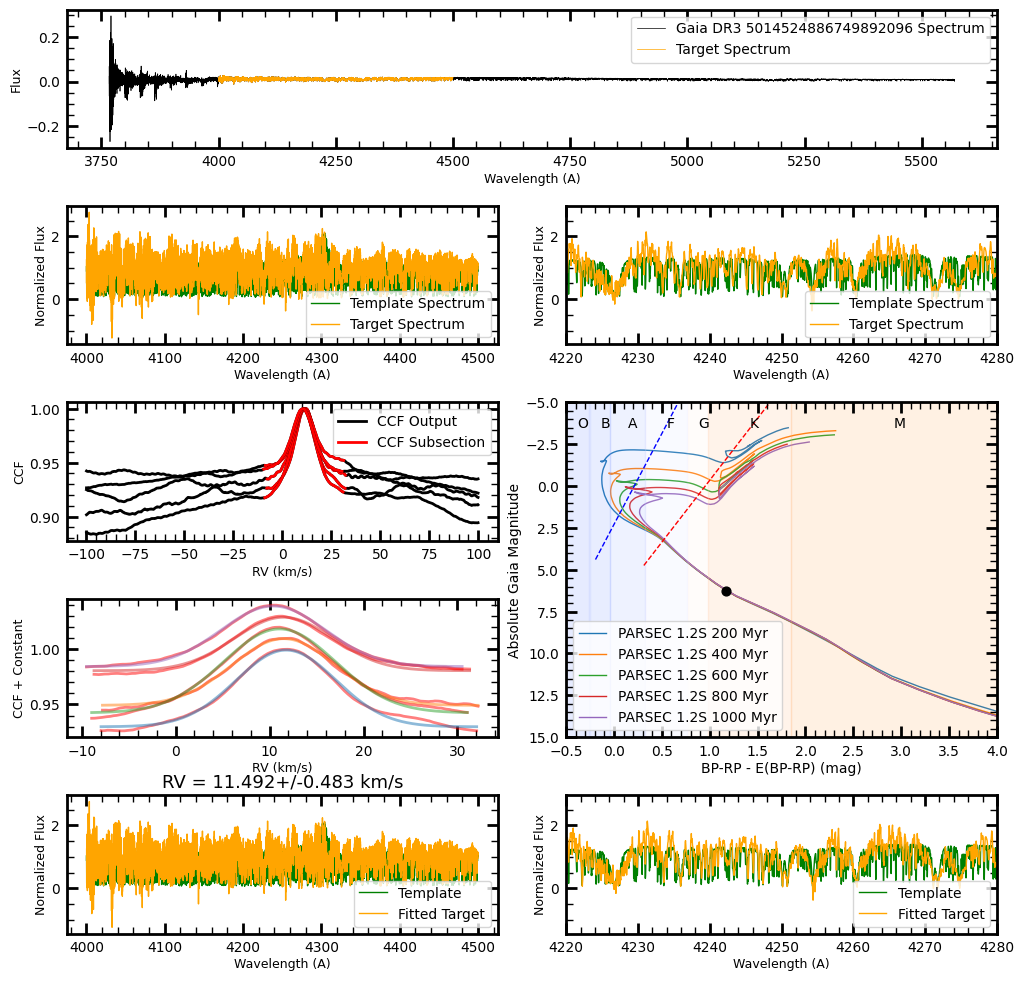

11.492

In [ ]:
target_file = os.path.join(salt_files, "mbgphH202506040023_uwm.fits")    #use the *_uwm.fits files downloaded from SALT. I recommend adding them all to a folder. I keep a subfolder of the ones I've already done (move after running)
template_file = G_temp

SALT_RV(target_file, template_file, minwl=4000, maxwl=4500, stepsize=0.05, split=5, rvmin=-100, rvmax=100, 
        parsec_file=parsec_file,start=200, end=1000, step=200, nlink=2000, nburnin=1000, gwidth=40)
#manually save this when you're happy with WL range etc to images folder